#### Import packages

Download the python chess package

In [1]:
# import packages to us
import os
import chess
import chess.engine
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
import numpy as np

#### Set up folders to stockfish (chess engine) and data csv file

Download stockfish from: https://stockfishchess.org/download/

I'm using version 15 here.

Download data from: http://csslab.cs.toronto.edu/datasets/#maia_kdd

I'm using the january CSV here

In [2]:
stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
chess_data_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Data'
chess_csv_file = 'lichess_db_standard_rated_2019-01.csv'
chess_data_fullfile = os.path.join(chess_data_folder,chess_csv_file)

#### Read in 1000 rows of data

Each row is a move from a game (game_id), made by a player (player_id), we also have elo, white/black, etc.
"board" gives the "fen" - this the location of each piece on the position - prior to the move
"clock" gives the clock time at the end of the turn.
"time_control" specifies what the initial clock setting is for each player (e.g. 600 seconds) and also how much time they get back after each move (this comes after the "+"). "move" specifies what move the player made. "white_active" specifies which player (black or white) made the move

In [82]:
data_raw = pd.read_csv(chess_data_fullfile, nrows=100000)
data_raw.head()

/var/folders/s3/06m5bv8s03v5c2y_thvlc6qr0000gp/T/ipykernel_84835/238190837.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(chess_data_fullfile, nrows=100000)


,game_id,type,result,white_player,black_player,white_elo,black_elo,time_control,num_ply,termination,white_won,black_won,no_winner,move_ply,move,cp,cp_rel,cp_loss,is_blunder_cp,winrate,winrate_elo,winrate_loss,is_blunder_wr,opp_winrate,white_active,active_elo,opponent_elo,active_won,is_capture,clock,opp_clock,clock_percent,opp_clock_percent,low_time,board,active_bishop_count,active_knight_count,active_pawn_count,active_queen_count,active_rook_count,is_check,num_legal_moves,opp_bishop_count,opp_knight_count,opp_pawn_count,opp_queen_count,opp_rook_count
0,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,0,e2e4,0.1,0.10,-0.02,False,0.5295,0.4758,0.0000,False,0.5244,True,1702,1628,False,False,600.0,600.0,0.000,0.000,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2,2,8,2,2,0,20,2,2,8,2,2
1,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,1,e7e5,0.12,-0.12,0.25,False,0.5244,0.4456,0.0192,False,0.5295,False,1628,1702,True,False,600.0,600.0,0.000,0.000,False,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,3,2,8,2,2,0,20,2,2,8,2,2
2,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,2,g1f3,0.37,0.37,0.14,False,0.5749,0.4994,0.0084,False,0.5052,True,1702,1628,False,False,598.0,600.0,0.003,0.000,False,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,2,2,8,2,2,0,29,2,2,8,2,2
3,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,3,b8c6,0.23,-0.23,-0.08,False,0.5134,0.4456,-0.0109,False,0.5664,False,1628,1702,True,False,599.0,598.0,0.002,0.003,False,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,3,2,8,2,2,0,29,2,2,8,2,2
4,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,4,f1c4,0.15,0.15,0.05,False,0.5295,0.4758,0.0000,False,0.5244,True,1702,1628,False,False,596.0,599.0,0.007,0.002,False,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,2,2,8,2,2,0,27,2,2,8,2,2


Filter data to only include moves from games with certain time-control settings, and compute estimated move-times for those games

In [68]:
# what game types do we care about? filter dataframe to only include these time-control settings (these occur on first page) - new name for df is data_filt
game_time_types = ['60+0', '120+1', '180+0',
                   '180+2', '300+0', '300+3',
                   '600+0', '600+5', '900+10',
                   '1800+0', '1800+20']

# filter based on if it's in these game settings... 
data_filt = data_raw.loc[data_raw.time_control.isin(game_time_types)].reset_index(drop = True)

# remove first move of each player (this is the first two move_plys - half-moves - of the game)
def filter_moves(game_data):
    filt_game_data = game_data.loc[game_data.move_ply > 2].reset_index(drop = True)
    return filt_game_data

data_filt = data_filt.groupby('game_id').apply(filter_moves).reset_index(drop=True)

# compute rt for each move, add this to the dataframe (new name - data_rt)
def add_rt(game_df):
    
    game_df = game_df.reset_index(drop = True)
    game_time_setting = game_df.time_control[0]
    time_back = 0

    if '+1' in game_time_setting:
        time_back = 1
    elif '+2' in game_time_setting:
        time_back = 2
    elif '+3' in game_time_setting:
        time_back = 3
    elif '+5' in game_time_setting:
        time_back = 5
    elif '+10' in game_time_setting:
        time_back = 10
    elif '+20' in game_time_setting:
        time_back = 20
    
    white_move_rts = time_back + game_df.loc[game_df.white_active == True, 'clock'].diff()*-1
    black_move_rts = time_back + game_df.loc[game_df.white_active == False, 'clock'].diff()*-1
    game_df.loc[game_df.white_active == True, 'rt'] = white_move_rts
    game_df.loc[game_df.white_active == False, 'rt'] = black_move_rts
    
    return game_df

data_rt = data_filt.groupby('game_id').apply(add_rt).reset_index(drop = True)


In [84]:
def get_stockfish_move(current_board):
    info = engine.analyse(current_board,limit=chess.engine.Limit(depth=15))
    stockfish_move = info['pv'][0].uci()
    
    return stockfish_move

def is_move_backward(move, white_active):
    if white_active: 
        return int(move[3]) - int(move[1]) < 0
    else:
        return int(move[3]) - int(move[1]) > 0

#### Select example position

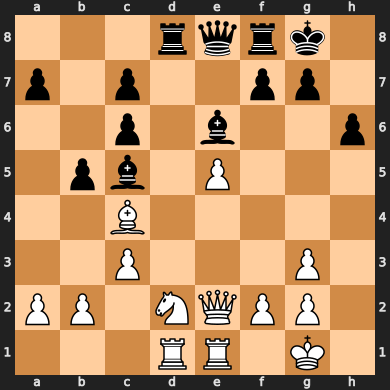

white to move
move selected: c4b3
move time: 12.0 seconds
stockfish move: c4b3
was stockfish's move backwards?: True


In [93]:
data_idx = 31
this_row = data_rt.loc[data_idx,:]
this_fen = this_row.board
this_white_active = this_row.white_active
player_to_move = "white" if this_white_active else "black"

current_board = chess.Board(this_fen);

display(current_board)
print('{} to move'.format(player_to_move))

this_move = this_row.move
print('move selected: {}'.format(this_move))

this_rt = this_row.rt
print('move time: {} seconds'.format(this_rt))

stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

stockfish_move = get_stockfish_move(current_board)
print('stockfish move: {}'.format(stockfish_move))

sf_move_backward = is_move_backward(stockfish_move, this_white_active)
print("was stockfish's move backwards?: {}".format(sf_move_backward))


#### Run many games

In [70]:
stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

#stockfish_move_list = []
#player_move_list = []
#move_backward_list = []

n_moves = 10000

for data_idx in range(807,n_moves):
    
    print(data_idx, end = ' ')
    
    this_row = data_rt.loc[data_idx,:]
    this_fen = this_row.board
    this_white_active = this_row.white_active
    
    this_board = chess.Board(this_fen)
    stockfish_move = get_stockfish_move(this_board)
    
    move_backward = is_move_backward(stockfish_move, this_white_active)
    
    player_move = this_row.move
    
    stockfish_move_list.append(stockfish_move)
    player_move_list.append(player_move)
    move_backward_list.append(move_backward)
    

#results_df = pd.DataFrame({'stockfish_move': stockfish_move_list, 'player_move': player_move_list, 'move_backward': move_backward_list})

807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 104

KeyboardInterrupt: 

In [75]:
results_df = pd.DataFrame({'stockfish_move': stockfish_move_list, 'player_move': player_move_list, 'move_backward': move_backward_list})

In [80]:
results_df.move_backward.mean()

0.13655352480417754

In [77]:
results_df['player_matches_stockfish'] = results_df.stockfish_move == results_df.player_move

In [78]:
results_df.groupby('move_backward').mean()

,player_matches_stockfish
move_backward,
False,0.379800
True,0.376673
